# Finding feature maps that are maximally activated by a specific image
## Network used: VGG16

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from cv2 import resize
import matplotlib.gridspec as gridspec
from math import ceil
from IPython.display import HTML
from pdb import set_trace
# from scipy import ndimage

In [0]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

In [0]:
class FilterVisualizer():
    def __init__(self):
        self.model = vgg16(True).cuda().eval()
        set_trainable(self.model, False)

    def visualize(self, sz, layer, filter, upscaling_steps=12, upscaling_factor=1.2, lr=0.1, opt_steps=20, blur=None, save=False, print_losses=False):

        img = (np.random.random((sz, sz, 3)) * 20 + 128.)/255.
#         img = np.random.uniform(0, 1, size=(sz, sz, 3)).astype(np.float32)
#         median_filter_size = 4 if sz < 100 else 8
#         img = scipy.ndimage.filters.median_filter(img, [median_filter_size,median_filter_size,1])
    
        layer = children(self.model)[layer]
        activations = SaveFeatures(layer)  # register hook

        for i in range(upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            if i > upscaling_steps/2:
                opt_steps_ = int(opt_steps*1.3)
            else:
                opt_steps_ = opt_steps
            for n in range(opt_steps_):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                if print_losses:
                    if i%3==0 and n%5==0:
                        print(f'{i} - {n} - {float(loss)}')
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(np.rollaxis(to_np(img_var.data),1,4))[0]
            self.output = img
            sz = int(upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        if save:
            self.save(layer, filter)
        activations.close()
        return np.clip(self.output, 0, 1)
    
    def most_activated(self, image, layer, limit_top=None):

        train_tfms, val_tfms = tfms_from_model(vgg16, 224)
        transformed = val_tfms(image)
#         set_trace()
        layer = children(self.model)[layer]
        activations = SaveFeatures(layer)  # register hook
        self.model(V(transformed)[None]);
        #         set_trace()
#         print(activations.features.shape)
        #         set_trace()
        mean_act = [activations.features[0,i].mean().data.cpu().numpy()[0] for i in range(activations.features.shape[1])]
        activations.close()
        return mean_act
           
    def get_transformed_img(self,img,sz):
        train_tfms, val_tfms = tfms_from_model(resnet34, sz)
        return val_tfms.denorm(np.rollaxis(to_np(val_tfms(img)[None]),1,4))[0]

In [0]:
FV = FilterVisualizer()

In [0]:
FV.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [0]:
import requests
import base64
import pprint

In [0]:
with open('img_at.txt') as f:
    ACCESS_TOKEN = f.read().strip()

In [0]:
def upload_to_imgur(file_name,post_title,album_hash):
    url = 'https://api.imgur.com/3/image'
    fh = open(file_name, 'rb');
    payload = {'image': base64.b64encode(fh.read()),
              'album':album_hash,
              'type':'base64',
              'title':post_title,
              'looping':False
              }
    files = {}
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}'
    }
    response = requests.request('POST', url, headers = headers, data = payload, files = files, allow_redirects=False)
#     print(response.json()['data']['link'])
    return response.json()['data']['link']

In [0]:
def plot_reconstructions(imgs,layer_idx,filters,n_cols=3, cell_size=4, save_fig=False,album_hash=None):
    n_rows = ceil((len(imgs))/n_cols)

    fig,axes = plt.subplots(n_rows,n_cols, figsize=(cell_size*n_cols,cell_size*n_rows))
          
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i>=len(filters):
            pass

        ax.set_title(f'fmap {filters[i]}')

        ax.imshow(imgs[i])
    fig.suptitle(f'VGG16 Layer: {layer_idx} : {children(FV.model)[layer_idx]}', fontsize="x-large",y=1.0)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    if save_fig:
        plt.savefig(f'vgg16_layer_{layer_idx}_fmaps_{"_".join([str(f) for f in filters])}.png')
        link = upload_to_imgur(f'vgg16_layer_{layer_idx}_fmaps_{"_".join([str(f) for f in filters])}.png',
                        f'vgg16_layer_{layer_idx}_fmaps_{"_".join([str(f) for f in filters])}',album_hash)
        plt.close()
        return link
    else:
        plt.show()
        return None
    

In [0]:
def reconstructions(layer_idx, filters,
                    init_size=56, upscaling_steps=12, 
                    upscaling_factor=1.2, 
                    opt_steps=20, blur=5,
                    lr=1e-1,print_losses=False,
                    n_cols=3, cell_size=4,
                    save_fig=False,
                    album_hash=None):
    
    if save_fig:
        assert not album_hash is None
    imgs = []
    for filter in filters:
        imgs.append(FV.visualize(init_size,layer_idx, filter, 
                                 upscaling_steps=upscaling_steps, 
                                 upscaling_factor=upscaling_factor, 
                                 opt_steps=opt_steps, blur=blur,
                                 lr=lr,print_losses=print_losses))
        
    return plot_reconstructions(imgs,layer_idx,filters,
                         n_cols=n_cols,cell_size=cell_size,
                         save_fig=save_fig,album_hash=album_hash)

In [0]:
# l_idxs = [40]
# dd = 0
# for l in l_idxs:
#     start = 198
#     n_items_per_plot = 6
#     end =400
#     count = start
#     while count+n_items_per_plot<end:
#         dd+=1
#         print(f'reconstructions({l},list(range({count},{count+n_items_per_plot})),save_fig=True)')
#         reconstructions(l,list(range(count,count+n_items_per_plot)),save_fig=True)
#         count+=n_items_per_plot
# print(dd)

In [0]:
def image_from_url(url,file_name):
    !wget -qq "{url}" -O {file_name}
    return open_image(file_name)

In [0]:
def plot_activations_and_reconstructions(imgs,activations,filters,
                                         transformed_img,n_cols=3,
                                         cell_size=4,layer_name='',
                                         save_fig=False,album_hash=None):
    n_rows = ceil((len(imgs)+1)/n_cols)

    fig = plt.figure(figsize=(cell_size*n_cols,cell_size*n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols)
    tr_im_ax = plt.subplot(gs[0,0])
    tr_im_ax.grid(False)
    tr_im_ax.get_xaxis().set_visible(False)
    tr_im_ax.get_yaxis().set_visible(False)
    tr_im_ax.imshow(transformed_img)
    tr_im_ax.set_title('Image')
    
    act_ax = plt.subplot(gs[0, 1:])
    
    
    act = act_ax.plot(np.clip(activations,0.,None),linewidth=2.)
    for el in filters:
        act_ax.axvline(x=el, color='red', linestyle='--',alpha=0.4)
    act_ax.set_xlim(0,len(activations));
    act_ax.set_ylabel(f"mean activation");
    if layer_name == '':
        act_ax.set_title('Mean Activations')
    else:
        act_ax.set_title(f'{layer_name}')
    act_ax.set_facecolor('white')
    
    fmap_axes = []
    for r in range(1,n_rows):
        for c in range(n_cols):
            fmap_axes.append(plt.subplot(gs[r, c]))
            
    for i,ax in enumerate(fmap_axes):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i>=len(filters):
            pass

        ax.set_title(f'fmap {filters[i]}')

        ax.imshow(imgs[i])
    plt.tight_layout()
    save_name = layer_name.lower().replace(' ','_')
    if save_fig:
        plt.savefig(f'{save_name}.png')
        link = upload_to_imgur(f'{save_name}.png',
                        f'{save_name}',album_hash)
        plt.close()
        return link
    else:
        plt.show()
        return None

In [0]:
def activations_and_reconstructions(img,activation_layer,fmap_layer,
                                    top_num=4,init_size=56,
                                    upscaling_steps=12, upscaling_factor=1.2,
                                    opt_steps=20, blur=5,lr=1e-1,
                                    n_cols=3, cell_size=4,
                                    layer_name='',
                                    save_fig=False,
                                    album_hash=None):

    mean_acts = FV.most_activated(img,layer = activation_layer)

    most_act_fmaps = sorted(range(len(mean_acts)), key=lambda i: mean_acts[i])[-top_num:][::-1]

    imgs = []
    for filter in most_act_fmaps:
        imgs.append(FV.visualize(init_size,fmap_layer, filter, upscaling_steps=upscaling_steps, 
                                 upscaling_factor=upscaling_factor, 
                                 opt_steps=opt_steps, blur=blur,
                                 lr=lr,print_losses=False))
    transformed_img = FV.get_transformed_img(img,224)
    
    return plot_activations_and_reconstructions(imgs,mean_acts,
                                         most_act_fmaps,transformed_img,
                                         n_cols=n_cols,cell_size=cell_size,
                                         layer_name=layer_name,
                                         save_fig=save_fig,
                                         album_hash=album_hash)

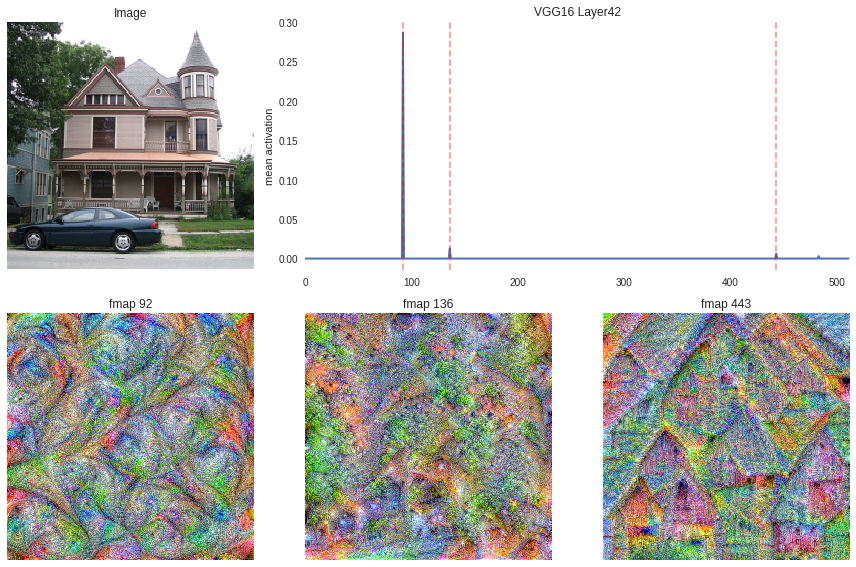

In [31]:
img = image_from_url('http://farm1.static.flickr.com/97/209577710_344cf9b77d.jpg','img.jpg')
img_url = activations_and_reconstructions(img,40,40,top_num=3,
                                layer_name='VGG16 Layer42',
                                save_fig=False)

## Running on more images

In [0]:
images = [
    'https://pbs.twimg.com/profile_images/871470043200094209/1UAyRdei_400x400.jpg',
    'http://farm3.static.flickr.com/2423/3957827131_90978df60b.jpg',
    'http://farm1.static.flickr.com/97/209577710_344cf9b77d.jpg',
    'http://farm1.static.flickr.com/232/500314013_56e18dd72e.jpg',
    'http://farm4.static.flickr.com/3283/2536420364_2cbb96fb64.jpg',
    'http://farm3.static.flickr.com/2418/1988187373_548be0682c.jpg',
    'http://farm4.static.flickr.com/3195/2703096506_8963dac892.jpg',
    'http://farm2.static.flickr.com/1093/883043423_8503b98702.jpg',
    'http://farm4.static.flickr.com/3220/2659962123_a5d9d9f080.jpg',
    'http://farm3.static.flickr.com/2420/2252055675_1ec3de9c46.jpg',
    'http://farm4.static.flickr.com/3216/2416297192_b4ff2a87d8.jpg',
    'http://farm4.static.flickr.com/3195/2690113895_507f0fb71a.jpg',
    'http://farm4.static.flickr.com/3097/2476598462_f5a95c12e4.jpg',
    'http://static.flickr.com/96/279601307_427e163e90_o.jpg',
    'http://farm3.static.flickr.com/2155/2485884251_6e28c59fdd.jpg',
    'http://farm4.static.flickr.com/3073/2820931609_3e5c8ceae2.jpg',
    'http://farm1.static.flickr.com/134/325737039_2cb3de029e.jpg',
    'http://farm3.static.flickr.com/2003/2047290079_c962beeb85.jpg',
    'http://farm3.static.flickr.com/2672/3729197896_e2fcb07887.jpg',
    'http://farm3.static.flickr.com/2419/2130941151_b100201751.jpg',
    'http://farm3.static.flickr.com/2446/3570779025_4748186d3f.jpg',
    'http://farm4.static.flickr.com/3504/3757435933_686e12d502.jpg',
    'http://farm4.static.flickr.com/3198/2408009683_9eb72cd5d1.jpg',
    'http://farm2.static.flickr.com/1389/1449509194_6b9a7f7003.jpg',
    'http://farm4.static.flickr.com/3147/2905958970_cf47a19ece.jpg',
    'http://farm4.static.flickr.com/3213/2845504219_4cd956bcf2.jpg',
    'http://farm3.static.flickr.com/2099/2233817436_3f20abe7df.jpg',
    'http://farm4.static.flickr.com/3176/2344377903_f5be963a37.jpg'
]

In [0]:
def create_imgur_album(title,description='',privacy='hidden'):
    url = 'https://api.imgur.com/3/album'
    payload = {
        'title': title,
        'description': description,
        'privacy':privacy}
    files = {}
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}'
    }
    response = requests.request('POST', url, headers = headers, data = payload, files = files, allow_redirects=False)
    print(f"https://imgur.com/a/{response.json()['data']['id']}")

In [0]:
for url in images:
    try:
        image = image_from_url(url,'dummy.jpg')
#         print(url)
        img_url = activations_and_reconstructions(image,40,40,top_num=3,
                                layer_name='VGG16 Layer40 Conv2d',
                                save_fig=True,
                                album_hash='1hnCw3I')
    except Exception as e:
        print(str(e))

## Selected Results

![vgg16_layer40_conv2d](https://i.imgur.com/UrPxtZQ.png)

---

![vgg16_layer40_conv2d](https://i.imgur.com/UGh0QDK.png)

---

![vgg16_layer40_conv2d](https://i.imgur.com/HYghyH8.png)

---

![vgg16_layer40_conv2d](https://i.imgur.com/qx5ogHE.png)

---

![vgg16_layer40_conv2d](https://i.imgur.com/CM1RDX9.png)

---

![vgg16_layer40_conv2d](https://i.imgur.com/DsT54rj.png)

---

![vgg16_layer40_conv2d](https://i.imgur.com/Hoa41Lu.png)

All results can be seen [here](https://imgur.com/a/1hnCw3I).